# Risk Analysis

The purpose of this section is to combine the CitiBike trip data with the NYC collision data to perform a risk analysis. The goal is two-fold:
1. Get a measure of risky stations
    - This can be used to warn users about to start their ride from a risky station.
    - Making risk salient may make users extra careful when riding and reduce the accident rate.
2. Create a model capable of predicting the risk associated with a ride from a particular station at a particular time.
    - Such a model is helpful for an insurance company to assess risk when providing ride insurance.
    - In turn, this may be integrated into the pricing strategy, so that the insurance pricing can depend on the station and time.

## 1. Risk measure of stations

In [16]:
import pandas as pd
collision = pd.read_csv("../data/processed/cleaned_collision_data.csv")

In [17]:
collision["CRASH DATETIME"] = pd.to_datetime(collision["CRASH DATETIME"], errors="coerce")

In [18]:
import duckdb

DATA_PATH = "../data/processed/citibike/*/*/data.parquet"

con = duckdb.connect("../data/processed/citibike/citibike.duckdb")

stations = con.execute("""
WITH trips AS (
    SELECT
        start_station_id,
        start_station_name,
        start_lat,
        start_lng,
        end_station_id,
        end_station_name,
        end_lat,
        end_lng
    FROM read_parquet($data_path)
),
stations_union AS (
    SELECT
        start_station_id AS station_id,
        start_station_name AS station_name,
        start_lat AS lat,
        start_lng AS lon
    FROM trips
    WHERE start_station_id IS NOT NULL
      AND start_lat IS NOT NULL
      AND start_lng IS NOT NULL

    UNION

    SELECT
        end_station_id AS station_id,
        end_station_name AS station_name,
        end_lat AS lat,
        end_lng AS lon
    FROM trips
    WHERE end_station_id IS NOT NULL
      AND end_lat IS NOT NULL
      AND end_lng IS NOT NULL
)
SELECT DISTINCT
    station_id,
    station_name,
    ROUND(lat::DOUBLE, 5) AS lat,
    ROUND(lon::DOUBLE, 5) AS lon
FROM stations_union
ORDER BY station_id
""", {"data_path": DATA_PATH}).df()


In [20]:
from sklearn.neighbors import BallTree
import numpy as np

# Prepare station coordinate tree (lat/lon → radians)
stations_rad = np.radians(stations[["lat", "lon"]].values)
tree = BallTree(stations_rad, metric="haversine")

# Query nearest station for each crash
crash_coords_rad = np.radians(collision[["LATITUDE", "LONGITUDE"]].values)
dist, idx = tree.query(crash_coords_rad, k=1)

# Convert radians → meters
dist_m = dist * 6371000  

collision["nearest_station_id"] = stations.iloc[idx.flatten()].station_id.values
collision["distance_m"] = dist_m.flatten()

# Filter only crashes within 300m
df_station = collision[collision["distance_m"] <= 300]


In [21]:
df_station["severity_weight"] = (
    1 * df_station["CYCLIST_INVOLVED"] +
    5 * df_station["NUMBER OF CYCLIST INJURED"] +
    100 * df_station["NUMBER OF CYCLIST KILLED"]
)

risk_raw = (
    df_station.groupby("nearest_station_id")["severity_weight"]
    .sum()
    .reset_index()
    .rename(columns={"severity_weight": "risk_raw"})
)


/var/folders/6c/gmnjxh5x1hn48qy93ptqpz580000gn/T/ipykernel_15472/3504216572.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_station["severity_weight"] = (


In [22]:
risk_raw["risk_norm"] = risk_raw["risk_raw"] / risk_raw["risk_raw"].max()


In [23]:
stations_with_risk = stations.merge(risk_raw, how="left", left_on="station_id",
                                    right_on="nearest_station_id")

stations_with_risk["risk_raw"] = stations_with_risk["risk_raw"].fillna(0)
stations_with_risk["risk_norm"] = stations_with_risk["risk_norm"].fillna(0)


In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: use risk_raw; swap to risk_norm if you prefer
risk_col = "risk_norm"  # or "risk_norm"

# Ensure no missing values
stations_with_risk[risk_col] = stations_with_risk[risk_col].fillna(0)

# --- Option A: least risky including zeros ---
least5 = stations_with_risk.sort_values(risk_col, ascending=True).head(5)

# --- Option B: least risky among stations with positive risk only ---
# least5 = (
#     stations_with_risk[stations_with_risk[risk_col] > 0]
#     .sort_values(risk_col, ascending=True)
#     .head(5)
# )

most5 = stations_with_risk.sort_values(risk_col, ascending=False).head(5)

# Combine and keep order (least first, then most)
plot_df = pd.concat([least5, most5], ignore_index=True)

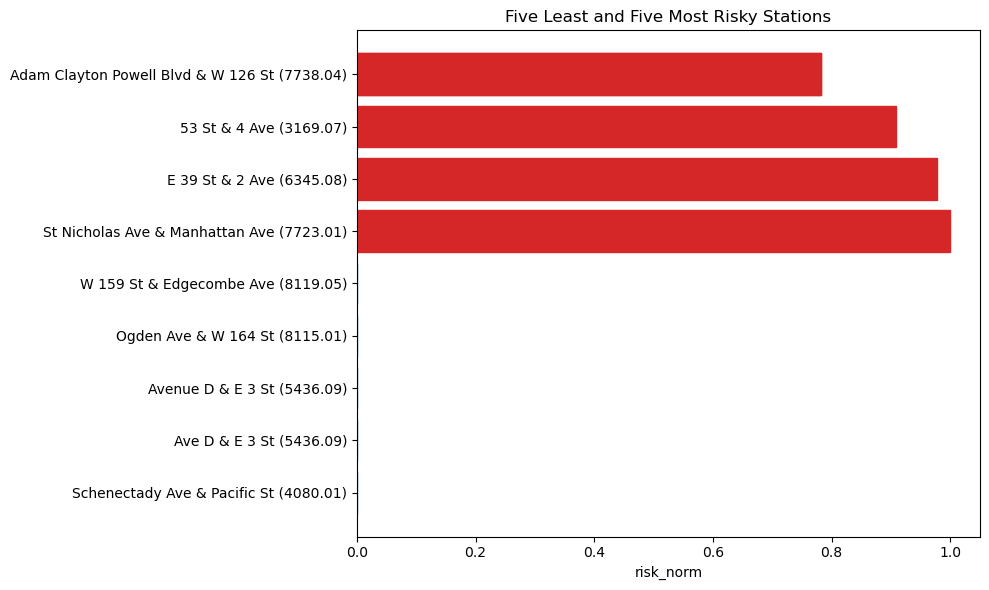

In [25]:
plt.figure(figsize=(10, 6))

# Horizontal bar plot
y_labels = plot_df["station_name"] + " (" + plot_df["station_id"].astype(str) + ")"
x_vals = plot_df[risk_col]

bars = plt.barh(y_labels, x_vals)

# Optional: color least vs most differently (first 5 = least, last 5 = most)
for i, bar in enumerate(bars):
    if i < 5:
        bar.set_color("tab:blue")   # least risky
    else:
        bar.set_color("tab:red")    # most risky

plt.xlabel(risk_col)
plt.title("Five Least and Five Most Risky Stations")
plt.tight_layout()
plt.show()


In [26]:
import folium
import numpy as np

df = stations_with_risk.copy()
df["risk_norm"] = df["risk_norm"].fillna(0)

center_lat = df["lat"].mean()
center_lon = df["lon"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles="cartodbpositron")

MAX_RADIUS = 25  # marker size scaling

for _, row in df.iterrows():

    radius = MAX_RADIUS * row["risk_norm"]
    radius = max(radius, 2)  # minimum radius
    
    # Color: low risk = light red, high risk = dark red
    # Scale 0 → 255
    intensity = int(255 * row["risk_norm"])
    color = f"#{intensity:02x}0000"  # this yields colors from #000000 to #ff0000

    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(
            f"<b>{row['station_name']}</b><br>"
            f"Risk (norm): {row['risk_norm']:.3f}<br>"
            f"Risk (raw): {row.get('risk_raw', 'NA')}",
            max_width=250,
        ),
    ).add_to(m)

m.save("station_risk_map.html")


In [28]:
stations_with_risk["risk_norm"].describe()

count    2567.000000
mean        0.115649
std         0.124641
min         0.000000
25%         0.025830
50%         0.077491
75%         0.153137
max         1.000000
Name: risk_norm, dtype: float64

In [30]:
import folium
import branca.colormap as cm

df = stations_with_risk.copy()
df["risk_norm"] = df["risk_norm"].fillna(0)

center_lat = df["lat"].mean()
center_lon = df["lon"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles="cartodbpositron")

MAX_RADIUS = 25
colormap = cm.linear.Reds_09.scale(0, 1)

for _, row in df.iterrows():

    radius = max(MAX_RADIUS * row["risk_norm"], 2)
    color = colormap(row["risk_norm"])

    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(
            f"<b>{row['station_name']}</b><br>"
            f"Risk (norm): {row['risk_norm']:.3f}<br>"
            f"Risk (raw): {row.get('risk_raw', 'NA')}",
            max_width=250,
        ),
    ).add_to(m)

m.save("station_risk_map_2.html")

In [35]:
risky_threshold = stations_with_risk["risk_norm"].quantile(0.95)
risky = stations_with_risk.loc[stations_with_risk["risk_norm"] >= risky_threshold].copy()

import folium
import branca.colormap as cm

df = risky  # only the filtered stations

center_lat = df["lat"].mean()
center_lon = df["lon"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles="cartodbpositron")

MAX_RADIUS = 40
colormap = cm.linear.Reds_09.scale(0, 1)

for _, row in df.iterrows():
    radius = max(MAX_RADIUS * row["risk_norm"], 4)
    color = colormap(row["risk_norm"])
    
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(
            f"<b>{row['station_name']}</b><br>"
            f"risk: {row['risk_norm']:.3f}<br>",
            max_width=250,
        ),
    ).add_to(m)

m


## 2. Predictive model of risk